<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/dtheory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian decision theory


In [ ]:
import numpy as np
np.set_printoptions(precision=3)

import pandas as pd

# From beliefs to actions

* Probabilistic inference let us compute our distribution over the possible **states of nature** $p(H=h|X=x)$; this is called our **belief state**. But ultimately we must convert beliefs into actions. 
* The optimal way to make **decisions under uncertainty** is to use **decision theory**.
* If the **decision maker** or **agent** picks action $a \in \cal{A}$ when the true state of nature is $h \in \cal{H}$, then we assume they incur a **loss** of $\ell(h,a)$.
* Since the state is usually hidden, we must compute the  the **expected loss** or **risk** for each action:
$$
R(a|x) = \sum_{h \in \cal{H}} p(h|x) \ell(h,a)
$$
* The **optimal policy** specifies which action to take for each possible observation so as to minimize this risk:
$$
a^* = \pi^*(x)  = \arg \min_{a \in \cal{A}} 
 \sum_{h \in \cal{H}} p(h|x) \ell(h,a)
$$
* Equivalently, we can **maximize expected utility**
$$
a^* = \pi^*(x) = \arg \max_{a \in \cal{A}} \sum_{h \in \cal{H}} p(h|x) U(h,a) 
$$


# Example:  Optimal policy for treating COVID patients

* Suppose we are a doctor who can either do nothing or give an expensive and painful drug to a patient.
* Suppose the patient either has or does not have COVID, and is either young or old.
* Suppose the loss function $\ell(h,a)$ is as shown below, where the units are [Quality Adjusted Life Years](https://en.wikipedia.org/wiki/Quality-adjusted_life_year#:~:text=The%20quality%2Dadjusted%20life%20year,one%20year%20in%20perfect%20health.). This matrix encodes the assumption that a young person is likely to live much longer than an old person, and that the drug is so bad that it is like losing 8 (quality-adjusted) years of life. (We will vary these assumptions later.)



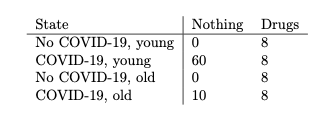

* We assume the age is a visible variable, but the COVID status is hidden.
* The doctor can use Bayes rule to infer $p(h|x)$, where $x$ is a diagnostic test.
* Given the belief state, we can compute the optimal policy, which is shown below. 
* We see that we should only give the drug to young people who test positive.

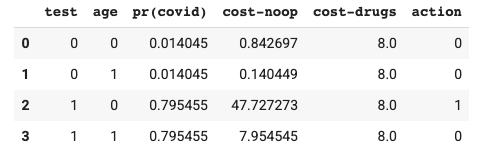

## Sensitivity to assumptions

* If we reduce the cost of the drug from 8 to 5, we get the new optimal policy shown below.
* Now we see that we should give the drug to anyone who tests positive.

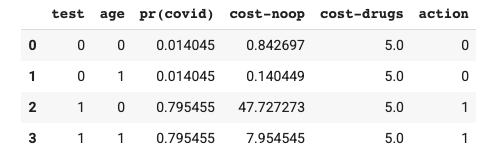

* If we keep the cost of the drug at 8, but increase the sensititivity of the test from 0.875 to 0.975, we get the new optimal policy shown below.
* Now we see that we should give the drug to anyone who tests positive, since the chance that they actually have COVID is higher.

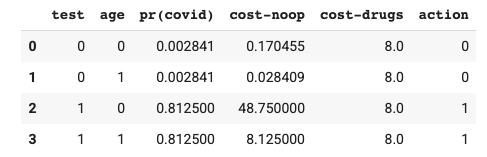

## Code to reproduce the above.

In [ ]:
def make_loss_fun(loss_drug=15):
  loss_covid_young = 60
  loss_covid_old = 10
  loss_mat = np.zeros((4, 2))
  loss_mat[0, :] = [0, loss_drug]
  loss_mat[1, :] = [loss_covid_young, loss_drug]
  loss_mat[2, :] = [0, loss_drug]
  loss_mat[3, :] = [loss_covid_old, loss_drug]
  return loss_mat

In [ ]:
loss_mat = make_loss_fun()
records = []
records.append(('No COVID, young', loss_mat[0,0], loss_mat[0,1]))
records.append(('COVID, young', loss_mat[1,0], loss_mat[1,1]))
records.append(('No COVID, old', loss_mat[2,0], loss_mat[2,1]))
records.append(('COVID, old', loss_mat[3,0], loss_mat[3,1]))

df = pd.DataFrame.from_records(records, columns=['State', 'Nothing', 'Drugs'])
display(df)

,State,Nothing,Drugs
0,"No COVID, young",0.0,15.0
1,"COVID, young",60.0,15.0
2,"No COVID, old",0.0,15.0
3,"COVID, old",10.0,15.0


In [ ]:
def normalize(x):
  return x / np.sum(x)

def posterior_covid(observed, prevalence=None, sensitivity=None):
  # observed = 0 for negative test, 1 for positive test
  # hidden state = 0 if no-covid, 1 if have-covid
  if sensitivity is None:
    sensitivity = 0.875
  specificity = 0.975
  TPR = sensitivity; 
  FNR = 1-TPR
  TNR = specificity
  FPR = 1-TNR
  # likelihood(hidden, obs)
  likelihood_fn = np.array([[TNR, FPR], [FNR, TPR]])
  # prior(hidden)
  if prevalence is None:
    prevalence = 0.1
  prior = np.array([1-prevalence, prevalence])
  likelihood = likelihood_fn[:, observed].T
  posterior = normalize(prior * likelihood)
  return posterior

In [ ]:
def compute_belief(obs, prevalence=None, sensitivity=None):
  test_result, age = obs
  # returns bel[0:3] for states (not-covid+not-old, covid+not-old, not-covid+old, covid+old)
  post = posterior_covid(test_result, prevalence, sensitivity)
  bel = np.zeros(4)
  if age==0:
    bel[0:2] = post
  else:
    bel[2:4] = post
  return bel


def policy(obs):
  bel = compute_belief(obs)
  loss_mat = make_loss_fun(loss_drug)
  expected_loss = np.dot(bel, loss_mat)
  return np.argmin(expected_loss)



In [ ]:
def make_table(cost_drug, prevalence=None, sensitivity=None):
  records = []
  for test_result in [0,1]:
    for age in [0,1]:
      obs = (test_result, age)
      bel = compute_belief(obs, prevalence, sensitivity)    
      loss_mat = make_loss_fun(cost_drug)
      expected_loss = np.dot(bel, loss_mat)
      act = np.argmin(expected_loss)
      if age==0:
        post_covid = bel[1]
      else:
        post_covid = bel[3]
      records.append((test_result, age, post_covid, expected_loss[0], expected_loss[1], act))

  df = pd.DataFrame.from_records(records, columns=['test', 'age', 'pr(covid)', 'cost-noop', 'cost-drugs', 'action'])
  return df


In [ ]:
df = make_table(cost_drug=8)
display(df)
print(df.to_latex(index=False, float_format="%.2f" ))


,test,age,pr(covid),cost-noop,cost-drugs,action
0,0,0,0.014045,0.842697,8.0,0
1,0,1,0.014045,0.140449,8.0,0
2,1,0,0.795455,47.727273,8.0,1
3,1,1,0.795455,7.954545,8.0,0


\begin{tabular}{rrrrrr}
\toprule
 test &  age &  pr(covid) &  cost-noop &  cost-drugs &  action \\
\midrule
    0 &    0 &       0.01 &       0.84 &        8.00 &       0 \\
    0 &    1 &       0.01 &       0.14 &        8.00 &       0 \\
    1 &    0 &       0.80 &      47.73 &        8.00 &       1 \\
    1 &    1 &       0.80 &       7.95 &        8.00 &       0 \\
\bottomrule
\end{tabular}



In [ ]:
df = make_table(cost_drug=5)
display(df)
print(df.to_latex(index=False, float_format="%.2f" ))

,test,age,pr(covid),cost-noop,cost-drugs,action
0,0,0,0.014045,0.842697,5.0,0
1,0,1,0.014045,0.140449,5.0,0
2,1,0,0.795455,47.727273,5.0,1
3,1,1,0.795455,7.954545,5.0,1


\begin{tabular}{rrrrrr}
\toprule
 test &  age &  pr(covid) &  cost-noop &  cost-drugs &  action \\
\midrule
    0 &    0 &       0.01 &       0.84 &        5.00 &       0 \\
    0 &    1 &       0.01 &       0.14 &        5.00 &       0 \\
    1 &    0 &       0.80 &      47.73 &        5.00 &       1 \\
    1 &    1 &       0.80 &       7.95 &        5.00 &       1 \\
\bottomrule
\end{tabular}



In [ ]:
df = make_table(cost_drug=8, sensitivity=0.975)
display(df)
print(df.to_latex(index=False, float_format="%.2f" ))

,test,age,pr(covid),cost-noop,cost-drugs,action
0,0,0,0.002841,0.170455,8.0,0
1,0,1,0.002841,0.028409,8.0,0
2,1,0,0.812500,48.750000,8.0,1
3,1,1,0.812500,8.125000,8.0,1


\begin{tabular}{rrrrrr}
\toprule
 test &  age &  pr(covid) &  cost-noop &  cost-drugs &  action \\
\midrule
    0 &    0 &       0.00 &       0.17 &        8.00 &       0 \\
    0 &    1 &       0.00 &       0.03 &        8.00 &       0 \\
    1 &    0 &       0.81 &      48.75 &        8.00 &       1 \\
    1 &    1 &       0.81 &       8.12 &        8.00 &       1 \\
\bottomrule
\end{tabular}



# Decision-theoretic classification

* In classification problems, the unknown state of nature is the "true" class label $y^* \in \cal{Y}$, where $\cal{Y} = \{1,\ldots,C\}$.
* We typically assume that the set of possible actions is to pick one of the labels, $\hat{y} \in \cal{Y}$. 
* We often assume a **zero-one** loss matrix $\ell(h,a)$, as follows:

$$
\begin{array}{c|cc}
 & \hat{y}=0 & \hat{y}=1  \\ \hline
 y^*=0 & 0 & 1  \\
 y^*=1 & 1 & 0
 \end{array}
$$
* We can write this more concisely as follows:
$$
\ell(y^*,\hat{y}) = I(y^* \neq \hat{y})
$$
* In this case,
the posterior expected loss is
$$
R(\hat{y}|x)
 = p(\hat{y} \neq y^* |x) = 1-p(y^*=\hat{y}|x)
$$
Hence the action that minimizes the expected loss is to choose the
most probable label:
$$
\pi(x)  = \arg \max_{y \in \cal{Y}} p(y|x)
$$
* This  corresponds to 
the **mode** of the posterior distribution,
also known as the **maximum a posteriori**
or  **MAP estimate**.



## Classification with a "reject" option

* In some applications (e.g., medicine, finance), we have an asymmetric loss, where the cost of a false positives is much higher than a cost of a false negative.
* In such settings, it is useful to allow for addition **rejection action**, in which we **refuse to classify** if we are uncertain. Such inputs can then be handled by some other system (e.g., a human).
* We define the loss function as follows:
$$
\ell(h, a) =
\left\{ \begin{array}{cc}
  0 & \mbox{if $h=a$ and $a \in \{1,\ldots,C\}$}\\
  \lambda_r & \mbox{if $a=0$}\\
  \lambda_e & \mbox{otherwise}
\end{array}
\right.
$$
where $\lambda_r$ is the cost of a rejection, and $\lambda_e$ is a cost of a misclassification error.
* It is easy to show that the optimal policy is as follows:
$$
\begin{align}
a^* &=
\begin{cases}
y^* & \text{ if } p(y^*|x) >  1-\frac{\lambda_r}{\lambda_e} \\
\text{reject} & \text{otherwise}
\end{cases}
\end{align}
$$
where $y^* = \arg \max_{y} p(y|x)$ is the MAP estimate.

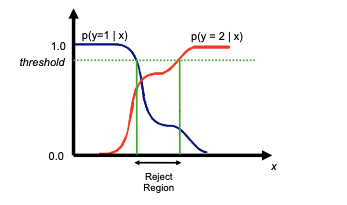